In [1]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph

In [2]:
from micrograd.engine import Value

In [9]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

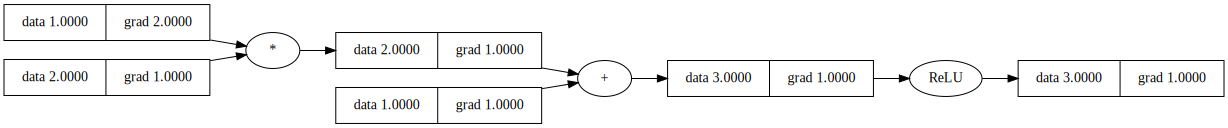

In [10]:
# a very simple example
x = Value(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

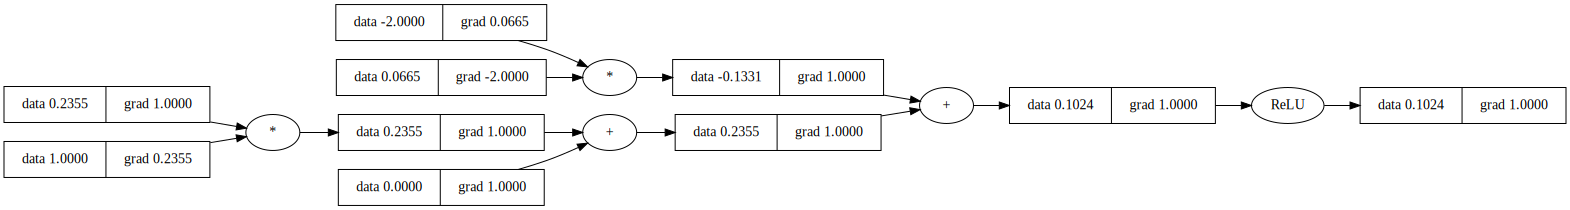

In [11]:
# a simple 2D neuron
import random
from micrograd import nn

random.seed(1337)
n = nn.Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
y.backward()

dot = draw_dot(y)
dot

In [6]:
dot.render('gout')

'gout.svg'

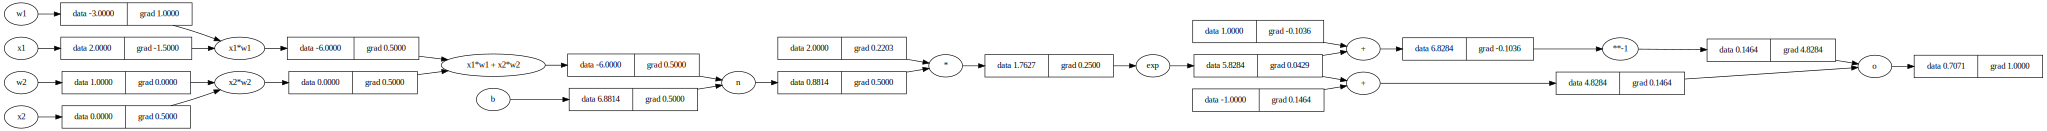

In [12]:
# inputs x1, x2
x1 = Value(2.0, _op='x1')
x2 = Value(0.0, _op='x2')
# weights w1, w2
w1 = Value(-3.0, _op='w1')
w2 = Value(1.0, _op='w2')
# bias b
b = Value(6.8813735870195432, _op='b')
# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1._op = 'x1*w1'
x2w2 = x2 * w2; x2w2._op = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._op = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n._op = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o._op = 'o'
o.backward()
draw_dot(o)


In [8]:
import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('b', b.grad.item())


0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
b 0.5000001283844369
